# Decision Tree

CART (Classification Trees), Breiman

Binary tree, minimize error in each leaf

## Lectures
- https://www.youtube.com/watch?v=p17C9q2M00Q&list=PLD0F06AA0D2E8FFBA&index=7 (ML 2.1 - ML 2.8) mathematicalmonk

## Regression Tree

## Growing a tree ("Greedy")

## Bootsrap aggregation (Bagging)

## Random forest

Based on http://gabrielelanaro.github.io/blog/2016/03/03/decision-trees.html Implementing Decision Trees in Python. It is ID3/C4.5, isn't CART algorithm

In [1]:
import numpy as np
# x1 is weather type (0 = partly cloudy, 1 = cloudy, 2 = sunny)
x1 = [0, 1, 1, 2, 2, 2]
# x2 is atmospheric pressure (0 = low, 1 = high)
x2 = [0, 0, 1, 1, 1, 0]
# y is rain 1 or not rain 0
y = np.array([0, 0, 0, 1, 1, 0])

def partition(a):
    return {c: (a==c).nonzero()[0] for c in np.unique(a)}

def entropy(s):
    res = 0
    val, counts = np.unique(s, return_counts=True)
    freqs = counts.astype('float') / len(s)
    for p in freqs:
        if p != 0.0:
            res -= p * np.log2(p)
    return res

def mutual_information(y, x):

    res = entropy(y)

    # We partition x, according to attribute values x_i
    val, counts = np.unique(x, return_counts=True)
    freqs = counts.astype('float')/len(x)

    # We calculate a weighted average of the entropy
    for p, v in zip(freqs, val):
        res -= p * entropy(y[x == v])

    return res

from pprint import pprint

def is_pure(s):
    return len(set(s)) == 1

def recursive_split(x, y):
    # If there could be no split, just return the original set
    if is_pure(y) or len(y) == 0:
        return y

    # We get attribute that gives the highest mutual information
    gain = np.array([mutual_information(y, x_attr) for x_attr in x.T])
    selected_attr = np.argmax(gain)

    # If there's no gain at all, nothing has to be done, just return the original set
    if np.all(gain < 1e-6):
        return y


    # We split using the selected attribute
    sets = partition(x[:, selected_attr])

    res = {}
    for k, v in sets.items():
        y_subset = y.take(v, axis=0)
        x_subset = x.take(v, axis=0)

        res['x_%d = %d' % (selected_attr, k)] = recursive_split(x_subset, y_subset)

    return res

X = np.array([x1, x2]).T
pprint(recursive_split(X, y))

{'x_0 = 0': array([0]),
 'x_0 = 1': array([0, 0]),
 'x_0 = 2': {'x_1 = 0': array([0]), 'x_1 = 1': array([1, 1])}}


Base on http://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/ How To Implement The Decision Tree Algorithm From Scratch In Python (Classification and regression tree algorithm - CART).

Used dataset from here http://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [67]:
def gini_index(groups, class_values):
    gini = 0.0
    for class_value in class_values:
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            proportion = [row[-1] for row in group].count(class_value) / float(size)
            gini += (proportion * (1.0 - proportion))
    return gini



# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

from csv import reader


# Load a CSV file
def load_csv(filename):
    file = open(filename, 'rt')
    lines = reader(file)
    # convert str -> float
    dataset = [list(map(float, row)) for row in lines]
    return dataset



# Select the best split point for a dataset
# (This is an exhaustive and greedy algorithm)
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}


# load and prepare data
filename = './dataset/data_banknote_authentication.csv'
dataset = load_csv(filename)

pprint(get_split(dataset))
# test Gini values
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))

{'groups': ([[0.32924, -4.4552, 4.5718, -0.9888, 0.0],
             [1.5356, 9.1772, -2.2718, -0.73535, 0.0],
             [1.2247, 8.7779, -2.2135, -0.80647, 0.0],
             [-1.5768, 10.843, 2.5462, -2.9362, 0.0],
             [0.80355, 2.8473, 4.3439, 0.6017, 0.0],
             [1.4479, -4.8794, 8.3428, -2.1086, 0.0],
             [0.3292, -4.4552, 4.5718, -0.9888, 0.0],
             [0.93584, 8.8855, -1.6831, -1.6599, 0.0],
             [0.7057, -5.4981, 8.3368, -2.8715, 0.0],
             [1.1432, -3.7413, 5.5777, -0.63578, 0.0],
             [-0.38214, 8.3909, 2.1624, -3.7405, 0.0],
             [-0.24811, -0.17797, 4.9068, 0.15429, 0.0],
             [1.4884, 3.6274, 3.308, 0.48921, 0.0],
             [-0.96511, 9.4111, 1.7305, -4.8629, 0.0],
             [-1.6162, 0.80908, 8.1628, 0.60817, 0.0],
             [-0.2062, 9.2207, -3.7044, -6.8103, 0.0],
             [-0.0068919, 9.2931, -0.41243, -1.9638, 0.0],
             [0.96441, 5.8395, 2.3235, 0.066365, 0.0],
             

In [99]:
import seaborn as sns
import matplotlib
# use color map, otherwise it will be grayscale
from matplotlib import cm
import matplotlib.pyplot as plt
# can choose different styles
# print(plt.style.available)
plt.style.use('fivethirtyeight')
# list available fonts: [f.name for f in matplotlib.font_manager.fontManager.ttflist]
matplotlib.rc('font', family='DejaVu Sans') 

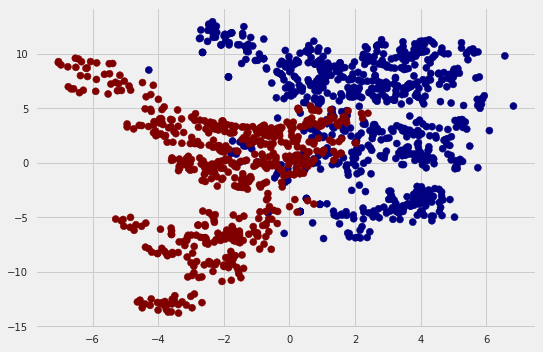

In [110]:
np_dataset = np.array(dataset)
y = np_dataset[:, -1]
# actually we could use 
plt.scatter(x=np_dataset[:, 0], y=np_dataset[:,1], c=[list(set(y)).index(y_value) for y_value in y], cmap=cm.jet)
plt.show()